# RvF - Starter Code Workbook

This is a workbook that you can upload to Google Colab to work on the project. It will download all the correct files and details to work on model development and improving.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Change this to the folder containing your Kaggle API key (kaggle.json)
#%env KAGGLE_KEY_FOLDER=mdst/w24-rvf
%env KAGGLE_KEY_FOLDER=
!mkdir data
!export KAGGLE_CONFIG_DIR=/content/drive/MyDrive/$KAGGLE_KEY_FOLDER && wget -O - "https://raw.githubusercontent.com/MichiganDataScienceTeam/W24-RvF/main/data/download.sh" | bash -s rvf10k

Streaming output truncated to the last 5000 lines.
  inflating: data/rvf10k/rvf10k/train/real/28056.jpg  
  inflating: data/rvf10k/rvf10k/train/real/28081.jpg  
  inflating: data/rvf10k/rvf10k/train/real/28160.jpg  
  inflating: data/rvf10k/rvf10k/train/real/28181.jpg  
  inflating: data/rvf10k/rvf10k/train/real/28190.jpg  
  inflating: data/rvf10k/rvf10k/train/real/28192.jpg  
  inflating: data/rvf10k/rvf10k/train/real/28194.jpg  
  inflating: data/rvf10k/rvf10k/train/real/28197.jpg  
  inflating: data/rvf10k/rvf10k/train/real/28199.jpg  
  inflating: data/rvf10k/rvf10k/train/real/28247.jpg  
  inflating: data/rvf10k/rvf10k/train/real/28281.jpg  
  inflating: data/rvf10k/rvf10k/train/real/28308.jpg  
  inflating: data/rvf10k/rvf10k/train/real/28316.jpg  
  inflating: data/rvf10k/rvf10k/train/real/28332.jpg  
  inflating: data/rvf10k/rvf10k/train/real/28342.jpg  
  inflating: data/rvf10k/rvf10k/train/real/28345.jpg  
  inflating: data/rvf10k/rvf10k/train/real/28347.jpg  
  inflating: d

In [ ]:
!rm -r W24-RvF starter_code
!git clone -q https://github.com/MichiganDataScienceTeam/W24-RvF.git
!mv W24-RvF/starter_code .
!rm -r W24-RvF

rm: cannot remove 'W24-RvF': No such file or directory
rm: cannot remove 'starter_code': No such file or directory


**KEY**: Make sure to save your work after every meeting! We recommend you do so via GitHub, but its not necessary.

The following sample code is the basics you need to get started with model development.

In [ ]:
import torch
import torchvision
import cv2
import torchvision.transforms.v2 as v2
from starter_code.dataset import RvFDataset, get_loaders
from starter_code.train import train_model, plot_performance, load_model

In [ ]:
train_dataset = RvFDataset("train", data_directory = "data/rvf10k")

In [ ]:
mean = torch.zeros((3,))
variance = torch.zeros((3,))
tensor_converter = v2.ToTensor()

for image, _ in train_dataset:
    mean += tensor_converter(image).mean(dim=(1, 2))
    mean /= len(train_dataset)
for image, _ in train_dataset:
    image = tensor_converter(image)
    variance += ((image - mean.view(3, 1, 1))**2).mean(dim=(1,2))

std = torch.sqrt(variance / len(train_dataset))

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [ ]:
def preprocess(image) -> torch.Tensor:
    tensor = torch.tensor(image, dtype = torch.float32).permute(2, 0, 1)
    tight = torch.from_numpy(cv2.Canny(image, 118, 128)).view(1, 256, 256) # Edge.
    tensor = v2.Normalize(mean = mean, std = std)(tensor)
    tensor =  v2.ColorJitter(brightness=.5, hue=.3)(tensor) # Color.
    tensor = v2.GaussianBlur(kernel_size = (5, 9), sigma = (0.1, 5.))(tensor) # Blur.
    tensor = torch.dstack([tensor.permute(1, 2, 0), tight.permute(1, 2, 0)]).permute(2, 0, 1)
    return tensor

    #mean = torch.zeros((3,))
    #variance = torch.zeros((3,))
    #tensor_converter = v2.ToTensor()

    #for image, _ in train_dataset:
    #    mean += tensor_converter(image).mean(dim=(1, 2))
    #    mean /= len(train_dataset)
    #for image, _ in train_dataset:
    #    image = tensor_converter(image)
    #    variance += ((image - mean.view(3, 1, 1))**2).mean(dim=(1,2))

    #std = torch.sqrt(variance / len(train_dataset))
    # TODO: Edit this function to more preprocessing steps to improve model performance.
    #tight = torch.from_numpy(cv2.Canny(image.permute(1,2,0).numpy(), 240, 250)).view(1, 500, 500)
    #return torch.dstack([image, tight]) # Add an extra channel for edges


    #tensor_converter = v2.Compose([ # Step 0: Convert from PIL Image to Torch Tensor
    #    v2.ToImage(),
    #    v2.ToDtype(torch.float32, scale=True)
    #])
    #normalizer = v2.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2532, 0.2496, 0.2681]) # Step 1. Normalize the image
    #cropper = v2.RandomCrop(size=(28, 28))
    #blurrer = v2.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5.))

    #preprocessor = v2.Compose([
    #tensor_converter,
    #normalizer,
    #cropper,
    #blurrer])
    #tensor = torch.tensor(image, dtype=torch.float32)
    #return tensor.permute(2,0,1)

In [ ]:
class Model(torch.nn.Module):
    def __init__(self):
      """Constructor for the neural network."""
      super(Model, self).__init__()        # Call superclass constructor
      self.batchnorm = torch.nn.BatchNorm2d(num_features = 4)
      self.padding = torch.nn.ZeroPad2d(padding = 2)
      self.conv1 = torch.nn.Conv2d(in_channels = 4, out_channels = 16, kernel_size = 3, stride = 1)
      self.dropout = torch.nn.Dropout(p = 0.10)
      self.conv2 = torch.nn.Conv2d(in_channels = 16, out_channels = 128, kernel_size = 3, stride = 1)
      self.pool = torch.nn.MaxPool2d(kernel_size = 2, stride = 2)
      self.relu = torch.nn.ReLU()
      self.flatten = torch.nn.Flatten()
      self.fc = torch.nn.Linear(540800, 10)

    def forward(self, x):
      pa1 = self.padding(x)
      b1 = self.batchnorm(pa1)

      z1 = self.conv1(b1)
      d1 = self.dropout(z1)
      h1 = self.relu(d1)
      p1 = self.pool(h1)

      pa2 = self.padding(p1)

      z2 = self.conv2(pa2)
      d2 = self.dropout(z2)
      h2 = self.relu(d2)
      p2 = self.pool(h2)

      flat = self.flatten(p2)
      z = self.fc(flat)

      return z

Batch Accuracy: 0.83 , Total Accuracy: 0.63: 100%|██████████| 219/219 [02:27<00:00,  1.48it/s]


Epoch 1: Loss - (Train 285.56/Val 0.02), Accuracy - (Train 0.63/Val 0.73)


Batch Accuracy: 0.88 , Total Accuracy: 0.80: 100%|██████████| 219/219 [02:24<00:00,  1.51it/s]


Epoch 2: Loss - (Train 95.15/Val 0.02), Accuracy - (Train 0.80/Val 0.75)


Batch Accuracy: 0.88 , Total Accuracy: 0.92: 100%|██████████| 219/219 [02:24<00:00,  1.51it/s]


Epoch 3: Loss - (Train 45.12/Val 0.01), Accuracy - (Train 0.92/Val 0.78)


Batch Accuracy: 1.00 , Total Accuracy: 0.98: 100%|██████████| 219/219 [02:22<00:00,  1.54it/s]


Epoch 4: Loss - (Train 14.85/Val 0.02), Accuracy - (Train 0.98/Val 0.80)


Batch Accuracy: 0.96 , Total Accuracy: 1.00: 100%|██████████| 219/219 [02:20<00:00,  1.56it/s]


Epoch 5: Loss - (Train 4.45/Val 0.02), Accuracy - (Train 1.00/Val 0.79)


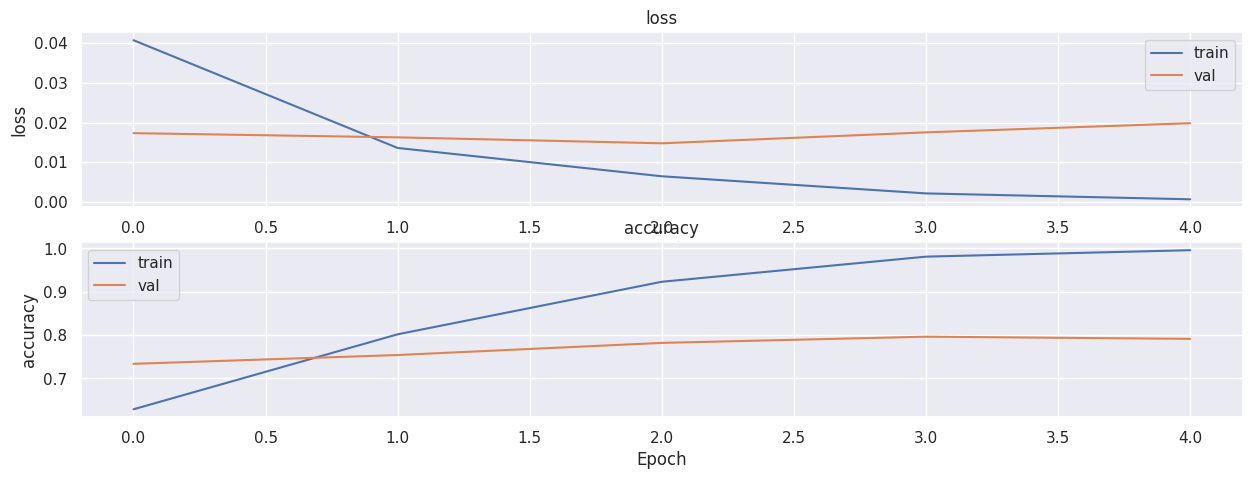

In [ ]:
train_loader, val_loader = get_loaders(preprocessor = preprocess, data_directory = "data/rvf10k")

model = Model()
optimizer = torch.optim.Adam(model.parameters(), lr = 5e-4) # TODO: Change the optimizer to explore different options
criterion = torch.nn.CrossEntropyLoss() # TODO: Change the criterion to explore different options

history = train_model(model, criterion, optimizer, train_loader, val_loader, epochs = 5)
plot_performance(history)

# Load the model from the training run
load_model(model, "checkpoints", 4) # change epoch from 0 to something else

**KEY**: At the end of each work session, submit this workbook via slack! This will allow the project leads to train your model on the larger 140k dataset over the week!